<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

# Building the Model

In [1]:
# Imports

# Gensim Imports
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import spacy

nlp = spacy.load('en_core_web_lg')

In [2]:
# Load in dataframe

path = './data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'

df = pd.read_csv(path)

df['brand'] = df['brand'].str.lower()  # Send brand to lower for later use.

df.sample()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
8263,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,These are a great value and seem to last almos...,Worth it. Don't overpay for brand names.,ByYousif A. Hassan,"https://www.barcodable.com/upc/841710106442,ht..."


In [3]:
reviews = df['reviews.text'].values.tolist()

In [4]:
def text_to_words(words):
    for word in words:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  # Note: deacc removes punctuation

reviews_text = list(text_to_words(reviews))

print(reviews_text[0])

['order', 'of', 'them', 'and', 'one', 'of', 'the', 'item', 'is', 'bad', 'quality', 'is', 'missing', 'backup', 'spring', 'so', 'have', 'to', 'put', 'pcs', 'of', 'aluminum', 'to', 'make', 'the', 'battery', 'work']


In [5]:
# Create bigram models for word grouping.
# Note: Higher Threshold = fewer bigrams / trigrams
# NOTE: Ended up not using.

bigram_mod = Phrases(reviews_text, min_count=5, threshold=100)

In [6]:
# Make a few functions....

# Remove Stopwords now
def no_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

# Bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): 
    
    text_list = []
    
    for sent in texts:
        doc = nlp(" ".join(sent))
        text_list.append([token.lemma_.lower() for token in doc if token.pos_ in allowed_postags])  # Tokenize / Append
    return text_list

In [7]:
rev_no_stops = no_stopwords(reviews_text)  # Remove Stop Words
# rev_bigrams = make_bigrams(rev_no_stops)   # Make bigrams

# Lemmatize reviews....
rev_lem = lemmatization(rev_no_stops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [8]:
id2word = corpora.Dictionary(rev_lem)  # Create dictionary

corpus = [id2word.doc2bow(text) for text in rev_lem]  # Send to bag of words as our corpus.

## Select Number of Topics & Fit Model

In [9]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    model_list : List of Models Used
    """
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=id2word,
                             num_topics=num_topics, random_state=42,
                             chunksize=125, workers=4)

        coherencemodel = CoherenceModel(model=model, dictionary=dictionary,
                                            corpus=corpus, coherence='u_mass')

        coherence_values.append({'num_topics': num_topics, 
                                 'coherence_score': coherencemodel.get_coherence()
                                })
        model_list.append(model)

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,
                                                        start=2, limit=40, step=3)

In [10]:
# Print the coherence values. This will tell us the best number of topics

for i, cv in zip(range(len(coherence_values)), coherence_values):
    cv = list(coherence_values)[i].get('coherence_score')
    num = list(coherence_values)[i].get('num_topics')
    print(f'===========================================\nModel Index: {i} - {num} Topics')
    print("Coherence Value:", cv)

Model Index: 0 - 2 Topics
Coherence Value: -2.550945402827841
Model Index: 1 - 5 Topics
Coherence Value: -3.0063140439726346
Model Index: 2 - 8 Topics
Coherence Value: -3.5374471055115864
Model Index: 3 - 11 Topics
Coherence Value: -3.969361782365446
Model Index: 4 - 14 Topics
Coherence Value: -4.220731630837193
Model Index: 5 - 17 Topics
Coherence Value: -4.283855534222532
Model Index: 6 - 20 Topics
Coherence Value: -4.413472724623429
Model Index: 7 - 23 Topics
Coherence Value: -4.549329922261006
Model Index: 8 - 26 Topics
Coherence Value: -4.878810014472398
Model Index: 9 - 29 Topics
Coherence Value: -4.696499983457039
Model Index: 10 - 32 Topics
Coherence Value: -5.061810434783133
Model Index: 11 - 35 Topics
Coherence Value: -5.221064776304066
Model Index: 12 - 38 Topics
Coherence Value: -5.38630988998417


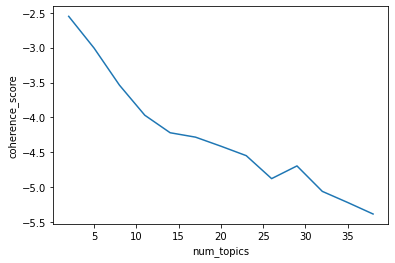

In [11]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

# Visualizations

In [12]:
# Import
import pyLDAvis.gensim

lda = model_list[4]

## Topic Distance Visualization

In [13]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.191370  0.030017       1        1  14.941072
2     -0.170513  0.124302       2        1  12.444246
9     -0.163637 -0.226481       3        1  12.352065
7     -0.079117  0.078517       4        1   8.774639
3     -0.090019  0.084743       5        1   7.453058
12    -0.151574 -0.047207       6        1   6.257907
1      0.221494 -0.185003       7        1   6.234426
0     -0.006583 -0.047022       8        1   5.648701
11     0.164704  0.141935       9        1   4.744927
5      0.081640 -0.212126      10        1   4.595119
8      0.170776  0.021333      11        1   4.593136
10    -0.064227  0.029999      12        1   4.181855
13     0.100996  0.095126      13        1   4.105724
6      0.177431  0.111866      14        1   3.673120, topic_info=         Term          Freq         Total Category  logprob  loglift
19      great  10522.000000  10522.000000  Default  30.0000  30.0000
45       good   7242.000000   7242.000000  Default  29.0000  29.0000
75       love   6334.000000   6334.000000  Default  28.0000  28.0000
1480      app   3149.000000   3149.000000  Default  27.0000  27.0000
10       work   4339.000000   4339.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
74      light     94.929161   1052.456787  Topic14  -4.7014   0.8984
19      great    139.320572  10522.180664  Topic14  -4.3178  -1.0203
254    decent     53.019501    347.794647  Topic14  -5.2839   1.4232
580   problem     57.043888    804.355530  Topic14  -5.2108   0.6579
137      time     53.261211   2701.782715  Topic14  -5.2794  -0.6223

[816 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
783      10  0.996569     ability
996       3  0.795601        able
996      10  0.202488        able
905       2  0.846292  absolutely
905       4  0.150004  absolutely
...     ...       ...         ...
87       12  0.007477        year
87       13  0.004078        year
876       5  0.888698       young
876       9  0.110307       young
2300      1  0.994482          yr

[2185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 10, 8, 4, 13, 2, 1, 12, 6, 9, 11, 14, 7])

## Overall Model and Documents

In [14]:
distro = [lda[d] for d in corpus]

def update(doc):
    d_dist = {k:0 for k in range(0, 12)}
    for t in doc:
        d_dist[t[0]] = t[1]
    return d_dist

new_distro = [update(d) for d in distro]

In [15]:
brands = df['brand'].values.tolist()  # Send brands to list.
topic_words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]  # Get topic words
topics = [' '.join(t[0:5]) for t in topic_words]

overall_model = pd.DataFrame.from_records(new_distro, index=brands)
overall_model.columns = topics

overall_model['brand'] = overall_model.reset_index()['index'].tolist()

overall_model.groupby('brand').mean()

,tablet good wife user friendly,great price product content value,book read purchase use game,buy internet access picture model,old tablet year buy gift,app great tablet download work,work excellent card expect connect,play game recommend long time,good screen price buy hd,love easy tablet use kid,kid want durable sale ipad,good product far quality price,child daughter case happy phone,lot money worth get need
brand,,,,,,,,,,,,,,
amazon,0.065680,0.061844,0.097807,0.055645,0.14498,0.047011,0.027426,0.059175,0.044784,0.192234,0.038319,0.033937,0.114915,0.054198
amazonbasics,0.039686,0.142448,0.072915,0.067122,0.05440,0.035967,0.084016,0.111490,0.085326,0.041634,0.044268,0.079728,0.061070,0.097691


# Notes and Observations

- The 'Amazon' brand contains actual electronics. Especially tablets, probably due to Kindle

- I found 'play game recommend long time' interesting, because you might expect it to be heavier in Amazon due to kindles/tablets and 'play game' however I'm thinking phrases such as 'last a long time' is going to be a lot less common in these product reviews, as you do expect a tablet to last a while, but not always a charger.

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling